In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import embedders
import torch

X, y, _ = embedders.dataloaders.load("temperature")
print(X.shape, y.shape)

# Normalize for norm to be 1
X[:, :3] = X[:, :3] / torch.norm(X[:, :3], p=2, dim=1, keepdim=True)

torch.Size([5352, 5]) torch.Size([5352])


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

MAX_DEPTH = None
# N_FEATURES = "d_choose_2"
N_FEATURES = "d"

# Train model

pm = embedders.manifolds.ProductManifold(signature=[(1, 2), (1, 1)])
# pm = embedders.manifolds.ProductManifold(signature=[(0, 5)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Product DT
pdt = embedders.tree_new.ProductSpaceDT(pm, max_depth=MAX_DEPTH, task="regression", n_features=N_FEATURES)
pdt.fit(X_train, y_train)
y_pred_pdt = pdt.predict(X_test).flatten()
print(f"ProductDT\t{torch.mean((y_pred_pdt - y_test) ** 2).item():.4f}")

# DT in ambient coords
dt = DecisionTreeRegressor(max_depth=MAX_DEPTH)
dt.fit(X_train.numpy(), y_train.numpy())
y_pred_dt = dt.predict(X_test.numpy())
print(f"Ambient DT\t{np.mean((y_pred_dt - y_test.numpy()) ** 2):.4f}")

# DT in tangent plane
X_log_train = pm.logmap(X_train).detach().numpy()
X_log_test = pm.logmap(X_test).detach().numpy()
tdt = DecisionTreeRegressor(max_depth=MAX_DEPTH)
tdt.fit(X_log_train, y_train.numpy())
y_pred_tdt = tdt.predict(X_log_test)
print(f"TangentDT\t{np.mean((y_pred_tdt - y_test.numpy()) ** 2)}")

# k-NN
knn = KNeighborsRegressor()
knn.fit(X_train.numpy(), y_train.numpy())
y_pred_knn = knn.predict(X_test.numpy())
print(f"kNeighbors\t{np.mean((y_pred_knn - y_test.numpy()) ** 2):.4f}")

ProductDT	39.6977
Ambient DT	3.4935
TangentDT	47.91063258636788
kNeighbors	48.5733


In [4]:
# Look at plots
N_POINTS = 101


def long_lat_to_xyz(X):
    long, lat = X[:, 0], X[:, 1]
    x = torch.cos(lat) * torch.cos(long)
    y = torch.cos(lat) * torch.sin(long)
    z = torch.sin(lat)
    return torch.stack([x, y, z], dim=1)


def xyz_to_long_lat(X):
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    long = torch.atan2(y, x)
    lat = torch.asin(z)
    return torch.stack([long, lat], dim=1)


# Get a meshgrid
_x_vals = torch.linspace(-torch.pi, torch.pi, N_POINTS)
_y_vals = torch.linspace(-torch.pi, torch.pi, N_POINTS)
_x_vals, _y_vals = torch.meshgrid(_x_vals, _y_vals)
_X = torch.stack([_x_vals.flatten(), _y_vals.flatten()], dim=1)
_X = long_lat_to_xyz(_X)

# Need to add 2 dimensions for month
jan_embedding = embedders.dataloaders._month_to_unit_circle_point("Jan")
_X = torch.cat([_X, torch.tensor(jan_embedding).expand(_X.shape[0], -1)], dim=1)

_y_pred = pdt.predict(_X).flatten()
_y_pred = _y_pred.reshape(N_POINTS, N_POINTS)

# Transform data to long-lat coords
X_transformed = xyz_to_long_lat(X)

/Users/phil/miniforge3/envs/embedders2/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


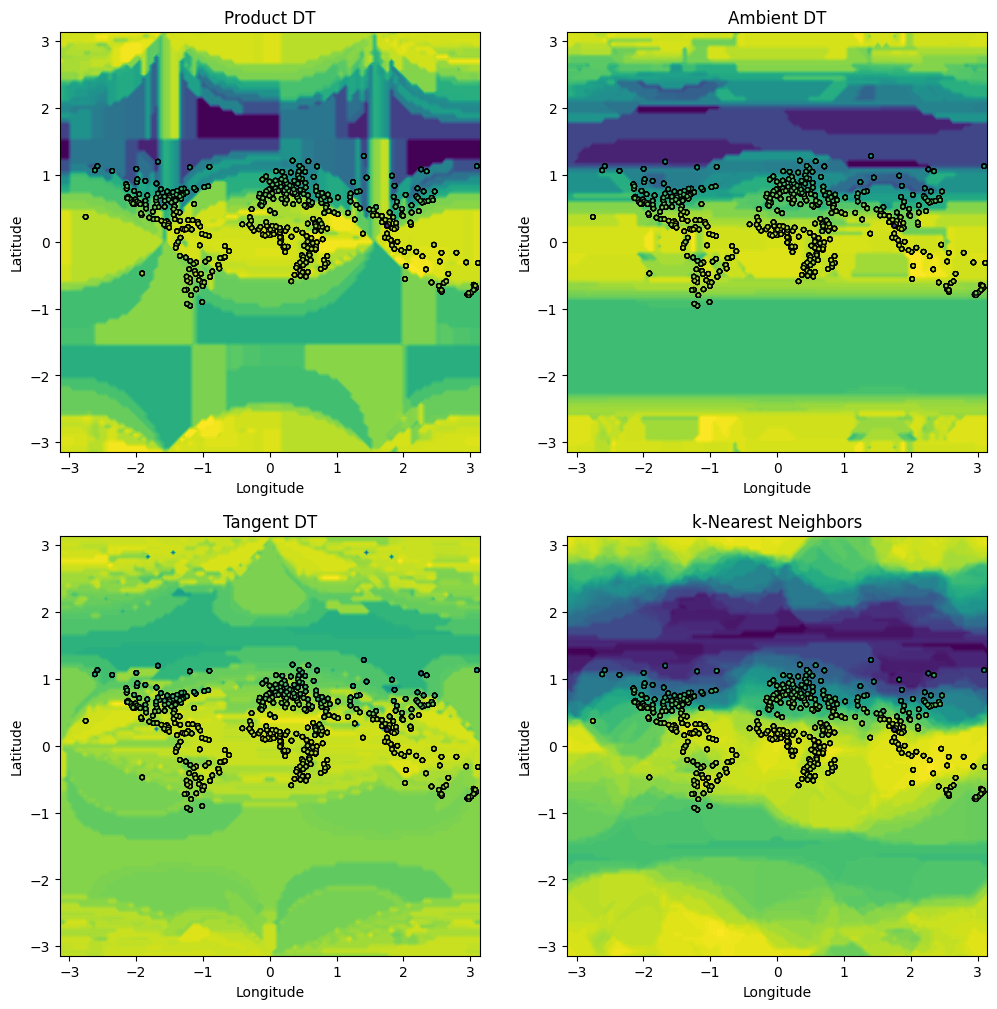

In [6]:
import matplotlib.pyplot as plt

# Plot surface in long, lat basis
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

axs[0, 0].contourf(_x_vals, _y_vals, pdt.predict(_X).numpy().reshape(N_POINTS, N_POINTS), levels=100)
axs[0, 0].set_title("Product DT")
axs[0, 1].contourf(_x_vals, _y_vals, dt.predict(_X).reshape(N_POINTS, N_POINTS), levels=100)
axs[0, 1].set_title("Ambient DT")
axs[1, 0].contourf(
    _x_vals, _y_vals, tdt.predict(pm.logmap(_X).detach().numpy()).reshape(N_POINTS, N_POINTS), levels=100
)
axs[1, 0].set_title("Tangent DT")
axs[1, 1].contourf(_x_vals, _y_vals, knn.predict(_X).reshape(N_POINTS, N_POINTS), levels=100)
axs[1, 1].set_title("k-Nearest Neighbors")

for ax in axs.flatten():
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect("equal")
    ax.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, cmap="viridis", edgecolors="black", s=9)

plt.show()

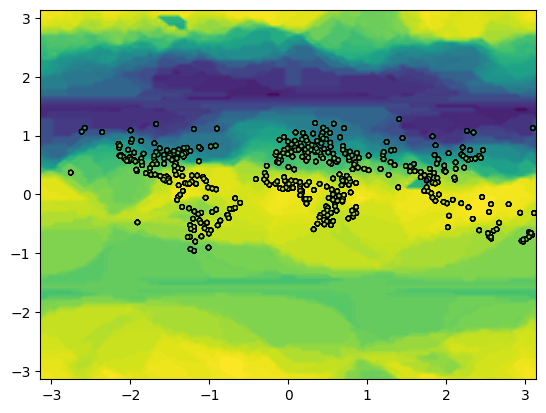

In [108]:
_y_pred = knn.predict(_X).flatten()
_y_pred = _y_pred.reshape(101, 101)

plt.figure()
plt.contourf(_x_vals, _y_vals, _y_pred, levels=100)
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, cmap="viridis", edgecolors="black", s=9)